<a href="https://www.kaggle.com/code/pmassouf/stock-price-simple-forecasting?scriptVersionId=102447167" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS.csv
/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS_monthly.csv
/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS_weekly.csv


In [2]:
 %config Completer.use_jedi = False #allows better autocompletion

# Table of contents

[Hyundai Stock Price Forecasting](#intro)

[Data Loading](#loading)

[Feature Engineering](#fing)

[Model](#model)

[Evaluation](#evalution)

[Improvements](#improvements)

<a id = "intro" ></a>
# Hyundai Stock Price Forecasting

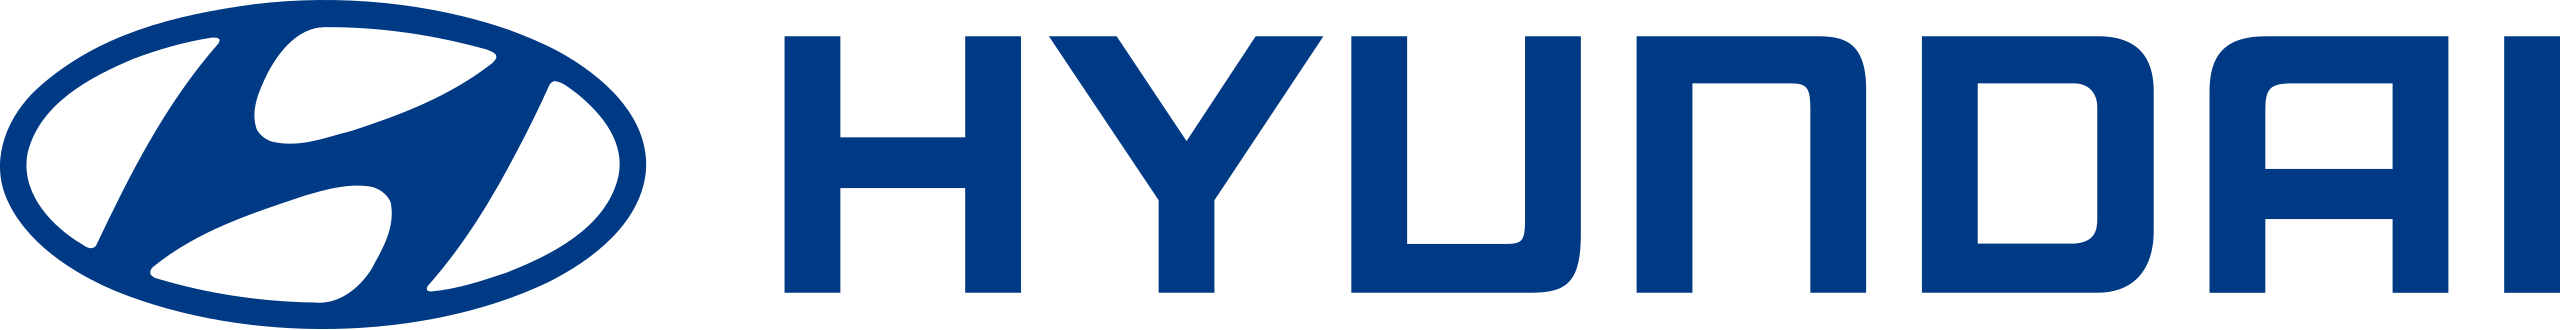

Hyundai is a South Korean automotive manufacturer.

Here we have a dataset containing Hyundai stock price and volume from the year 2016 to july 2022.

**The goal is to see if we can create a model that accurately describes the stock value of this company.**

<a id = "loading" ></a>
# Data Loading

In [3]:
df = pd.read_csv('/kaggle/input/hyundai-motor-company-stock-historical-price/005380.KS.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,147500.0,148000.0,143500.0,144000.0,122268.218750,445332
1,2016-01-05,143000.0,145000.0,142000.0,143500.0,121843.664063,530496
2,2016-01-06,144000.0,145000.0,139000.0,140000.0,118871.859375,769406
3,2016-01-07,138500.0,140000.0,137500.0,137500.0,116749.140625,586187
4,2016-01-08,134500.0,138000.0,133500.0,136500.0,115900.054688,888701
...,...,...,...,...,...,...,...
1608,2022-07-25,192500.0,198500.0,192500.0,196000.0,196000.000000,1352264
1609,2022-07-26,196000.0,196500.0,192500.0,196000.0,196000.000000,735482
1610,2022-07-27,196000.0,197000.0,193000.0,196000.0,196000.000000,608998
1611,2022-07-28,198000.0,198000.0,194000.0,195000.0,195000.000000,757504


We only have to keep the Close column

In [5]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Date'], axis = 1)
df

,Close
Date,
2016-01-04,144000.0
2016-01-05,143500.0
2016-01-06,140000.0
2016-01-07,137500.0
2016-01-08,136500.0
...,...
2022-07-25,196000.0
2022-07-26,196000.0
2022-07-27,196000.0


Let's plot the data:

<AxesSubplot:xlabel='Date'>

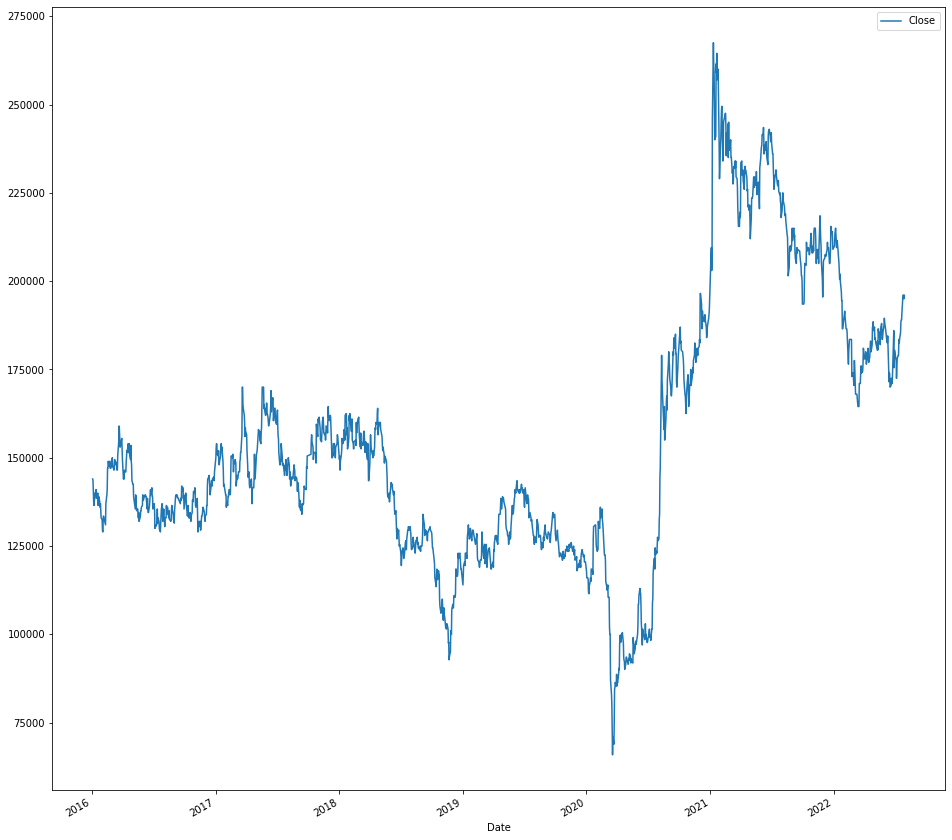

In [6]:

df.plot(y ='Close', figsize=(16, 16))


<a id = "fing"></a>
# Feature Engineering

We want to know what features we can add to the time series. Let's take a look at lag features

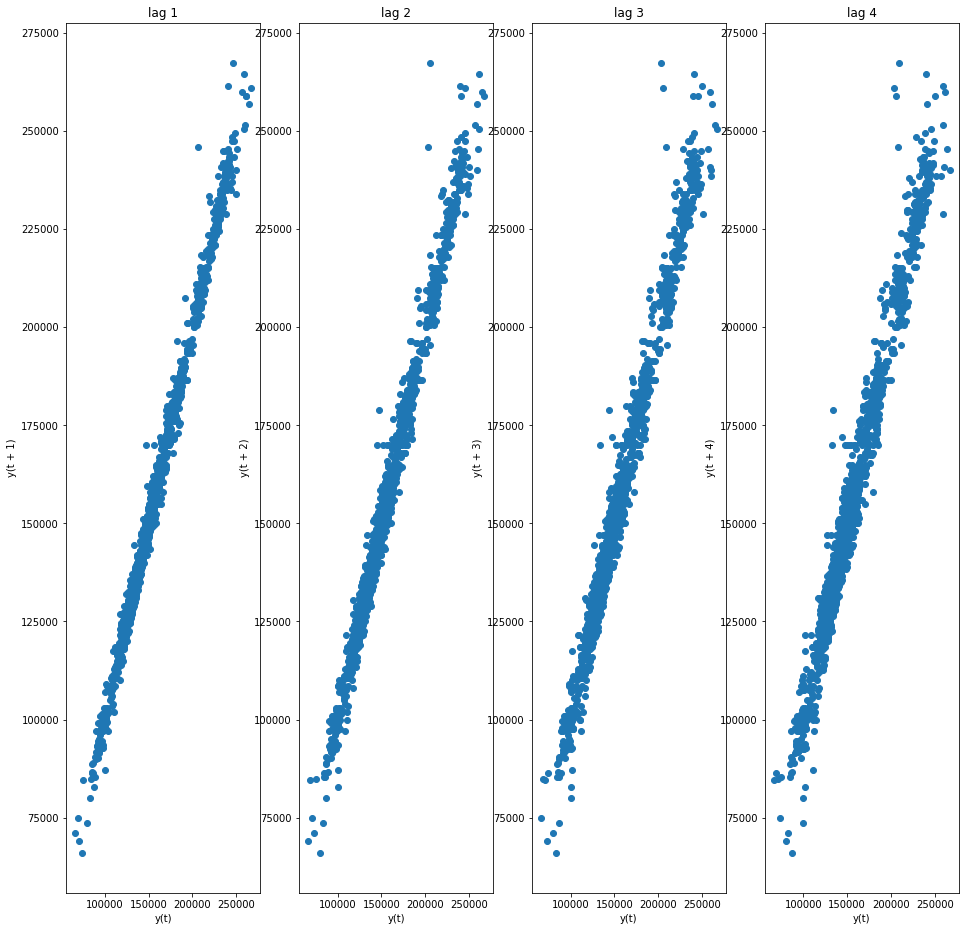

In [7]:
fig, axs = plt.subplots(ncols=4, figsize=(16,16))
for ax, i in zip(axs.flat, range(1,10)):
    pd.plotting.lag_plot(df, lag=i, ax=ax)
    ax.set_title('lag '+ str(i) )

plt.show()

As we can see, there is an important linear relationship between current stock values and past stock values.

Text(0.5, 0, 'lags')

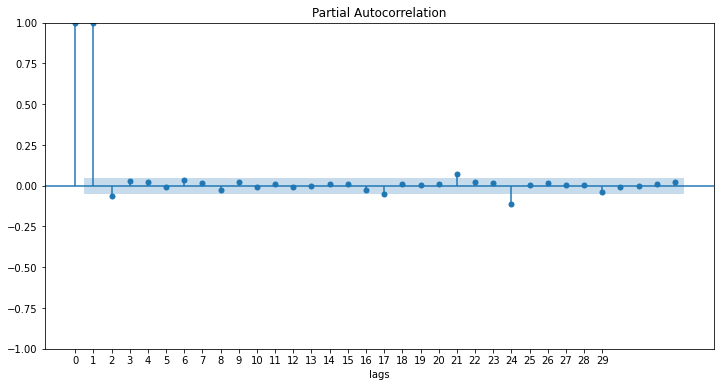

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
_, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df.dropna(), ax =ax, method = 'ywm')
ind = [i for i in range(30)]
ax.set_xticks(ind)
ax.set_xlabel('lags')

The partial autocorrelation shows that we can capture the dependance with lags 1, 2, 21 and 24. We'll create those features.

In [9]:
X = df.copy()
X['lag1'] = X['Close'].shift(1)
X['lag2'] = X['Close'].shift(2)
X['lag21'] = X['Close'].shift(21)
X['lag24'] = X['Close'].shift(24)

In [10]:
X = X.fillna(X.Close.mean())
X = X.drop(['Close'], axis= 1)

<a id = "model" ></a>
# Model 

Here we use a linear regression to predict the stock values using our training data

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = df['Close'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

Text(0.5, 1.0, 'ground truth and prediction plot')

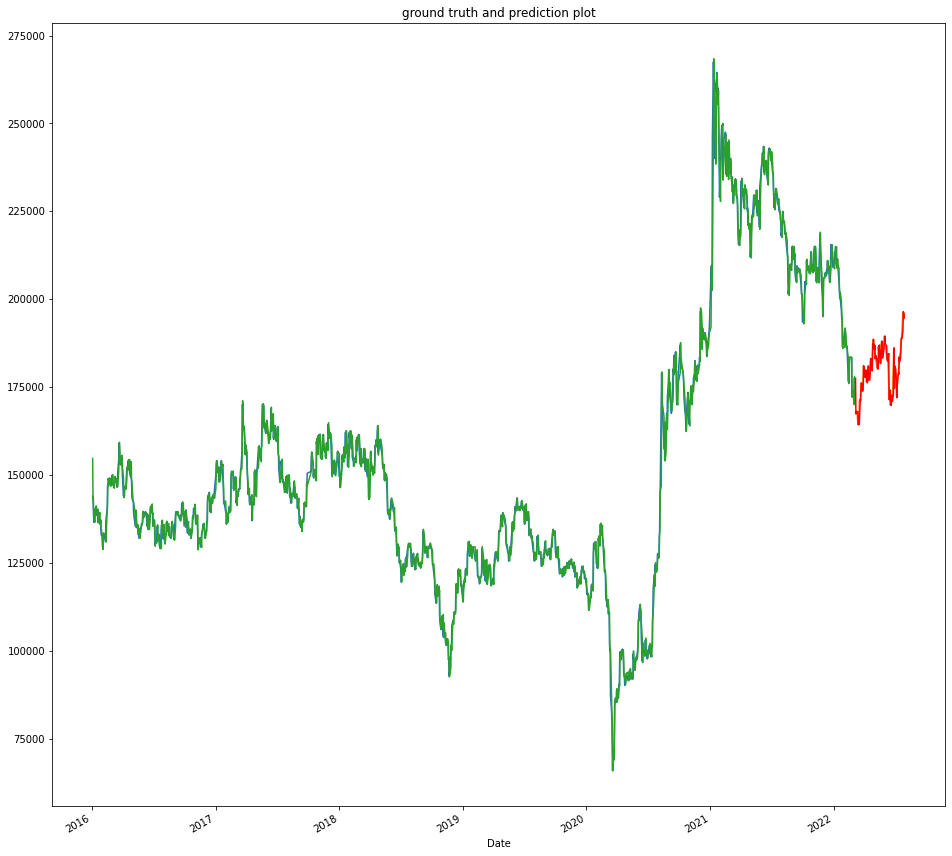

In [12]:
ax = y_train.plot()
ax = y_test.plot()
ax = y_pred.plot(ax=ax) #prediction for the training set
_ = y_fore.plot(ax=ax, color='red', figsize=(16,16)) #prediciton for the set 
ax.set_title('ground truth and prediction plot')

Let's zoom in, to see how accurate the model is

Text(0.5, 1.0, 'Train/prediction comparison')

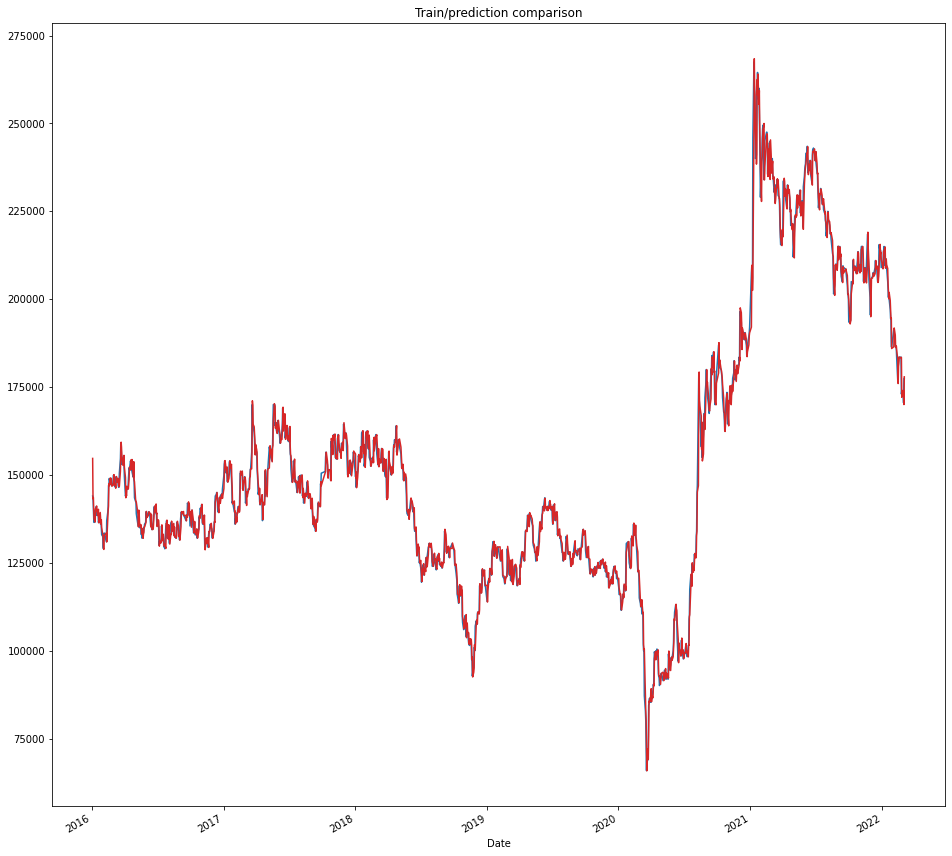

In [13]:
ax = y_train.plot()
_ = y_pred.plot(ax=ax, color='C3', figsize=(16, 16) )
ax.set_title('Train/prediction comparison')

Text(0.5, 1.0, 'Test/prediction comparison')

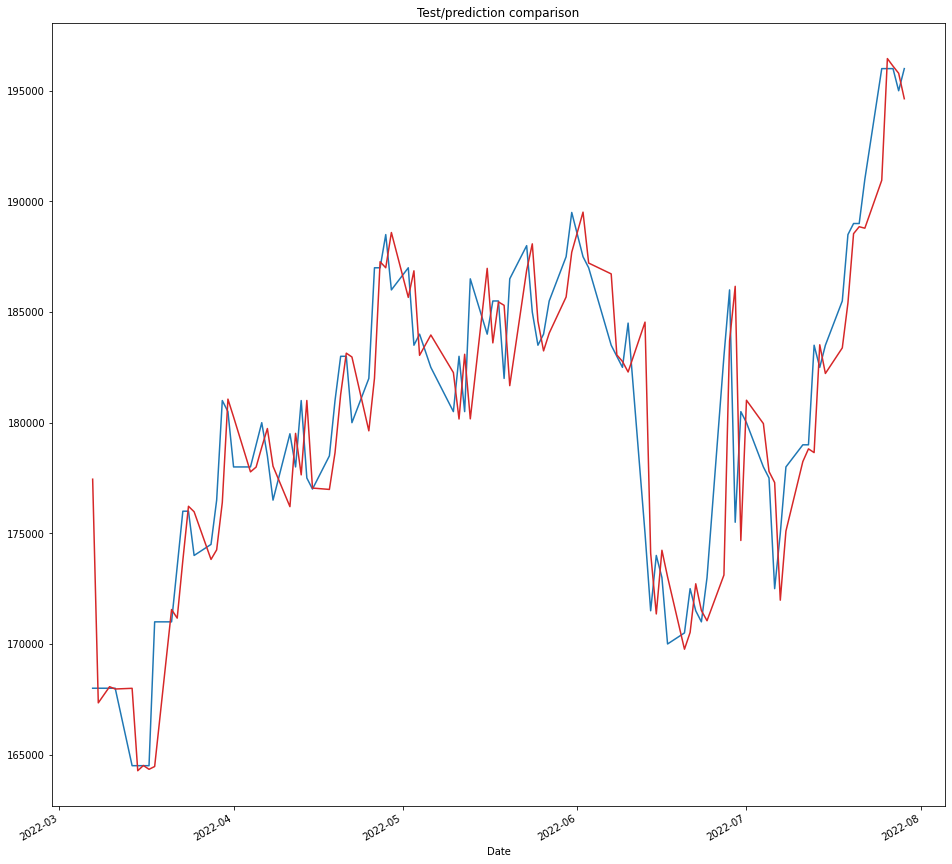

In [14]:
ax = y_test.plot()
_ = y_fore.plot(ax=ax, color='C3', figsize=(16, 16) )
ax.set_title('Test/prediction comparison')

<a id = "evalution" ></a>
# Evalutation

With a RMSE evalutation metric, we get :

In [15]:
train_rmse = mean_squared_error(y_train,y_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_fore, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 3250.76
Test RMSE: 3083.38


This is a good RMSE because the range of the stock price is large.

<a id = "improvements" ></a>
# Improvements

To get a better model, one could try different algorithms like ARIMA or create more features.
It is also possible to combine models.